[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

## Install Dependencies

In [1]:
!pip install mega.py

     |████████████████████████████████| 13.7MB 238kB/s 


## Download and Set up the working directory

In [0]:
import os

if 'Emotion Detection' not in os.listdir('.'):
  os.mkdir('Emotion Detection')

os.chdir("./Emotion Detection")

In [3]:
from mega import Mega

mega = Mega()

#login via anonymous user
m = mega.login()

# Don't cancel while downloading, Kindly wait for the download to finish
# Model Structure fer.json
m.download_url("https://mega.nz/file/#!3B01zThS!iQh0hZkLbz6P77ls_l5oeqKrVhbTj9s-0QM7Y8Vn88I")

# Model Weights fer.h5
m.download_url("https://mega.nz/file/#!PE8kiATA!P_JIP6eGF-DCgb0cYz4YY4BhOLvqNPnmOwf8w48dnic")

#Dataset fer2013.csv.zip
m.download_url("https://mega.nz/file/#!HM9nVa6Q!vpPRycYG7-SLVOC0quRRsGqwokGx24IuMNPRvL_h8QA")

# Extract the dataset
!unzip fer2013.csv.zip
!rm fer2013.csv.zip

Archive:  fer2013.csv.zip
  inflating: fer2013.csv             


## Import Libraries

In [0]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing import image
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from random import randint
from keras.applications.vgg16 import VGG16

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Data Exploration

In [5]:
df=pd.read_csv('fer2013.csv')

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
print("Emotion Labels are {0}".format(df.emotion.unique()))

Emotion Labels are [0 2 4 6 3 5 1]


## Prepare Data

In [0]:
num_labels = 7

# Split data to Train and Test data

X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")



In [0]:
# Convert to numpy array
X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

# Label encoding
train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

# Normalizing data between 0 and 1 
# Formula used (x - mean)/std

X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

# Reshape array to ( Num_of_images, height, width, channels )
# Image Resolution = 48 X 48
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


## Setup Model Architecture

In [0]:
num_features = 64
batch_size = 64
epochs = 10
width, height = 48, 48

In [0]:
# Designing the cnn
# 1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])


## Train the Model

In [0]:

#Training the model
model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)


## Load Model and Weights

In [10]:
#Saving the  model to  use it later on
# fer_json = model.to_json()
# with open("fer.json", "w") as json_file:
#     json_file.write(fer_json)
# model.save_weights("fer.h5")

#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')

face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)         

## Test the Model

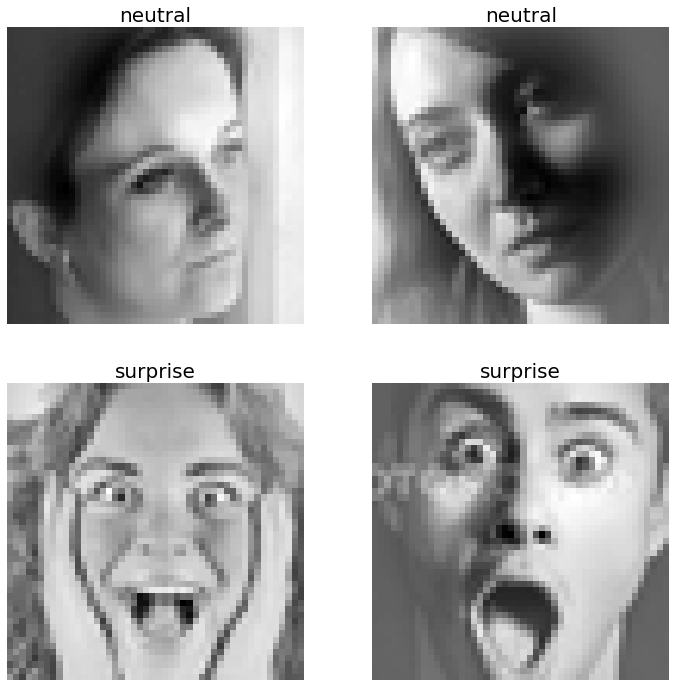

In [14]:
fig = plt.figure(figsize= (12, 12))

for i in range(1, 5):
  img_no = randint(0, X_test.shape[0] - 1)

  img_pixels = np.expand_dims(X_test[img_no], axis = 0)

  predictions = model.predict(img_pixels)

  #find max indexed array
  max_index = np.argmax(predictions[0])

  emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
  predicted_emotion = emotions[max_index]

  plt.subplot(2,2,i)
  plt.title(predicted_emotion,fontsize= 20 )
  plt.imshow(img_pixels.reshape(48, 48), cmap= "gray", interpolation="nearest")
  plt.axis("off")
  
plt.show()

## Test Realtime

This code will not work in Colab. Try it on your personal computer

In [0]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')


face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows